# Harmony Search Algorithms Applied to Portuguese Relation Extraction

## Load dataset

In [1]:
from source.datasets.dbpedia import DBpedia

In [2]:
dataset = DBpedia("data/DBpediaRelations-PT-0.2.txt")

In [3]:
print(f"number of samples: {len(dataset.data)}")

number of samples: 15392


In [4]:
print(f"number of positive samples: {sum(dataset.labels)}")

number of positive samples: 7696


In [5]:
dataset.data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

## Create features

In [6]:
from source.features.tagger import Tagger

In [7]:
tagger = Tagger()

In [8]:
features_raw = tagger.tag(dataset.data)

## Select data

In [12]:
import random
from sklearn.model_selection import train_test_split

In [13]:
random.seed(42)

In [14]:
# Remove incorrect samples

data, labels, features = [], [], []
for item, label, feature in zip(dataset.data, dataset.labels, features_raw):
    if feature:
        data.append(item)
        labels.append(label)
        features.append(feature)

In [15]:
# Resample due to time

N_SAMPLES = 2000

index = [i for i in range(0, len(features))]
index_sample = random.sample(index, N_SAMPLES)
features_sample = [features[i] for i in index_sample]
labels_sample = [labels[i] for i in index_sample]

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features_sample,
    labels_sample,
    train_size=0.7,
    random_state=42
)

In [17]:
print(f"number of train samples: {len(features_train)}")
print(f"number of test samples: {len(features_test)}")

number of train samples: 1400
number of test samples: 600


In [18]:
print(f"number of positive train samples: {sum(labels_train)}")
print(f"number of positive test samples: {sum(labels_test)}")

number of positive train samples: 677
number of positive test samples: 308


In [19]:
data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

In [20]:
features[0]

{'between': [100, 85, 92, 84, 85]}

In [21]:
tagger.convert_tags_to_strings(features[0])

{'between': ['VERB', 'ADP', 'NOUN', 'ADJ', 'ADP']}

## Original HS

In [22]:
from source.harmony_searches.original import OriginalHS

In [23]:
N_RUNS = 10
N_GENERATIONS = 500
N_HARMONIES = 50
N_PARAMETERS = 15
HMCR = 0.95
PAR = 0.5

In [24]:
original_hs = OriginalHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr=HMCR,
    par=PAR
)

In [25]:
%%time

original_hs.fit(features_train, labels_train)

Wall time: 10min 12s


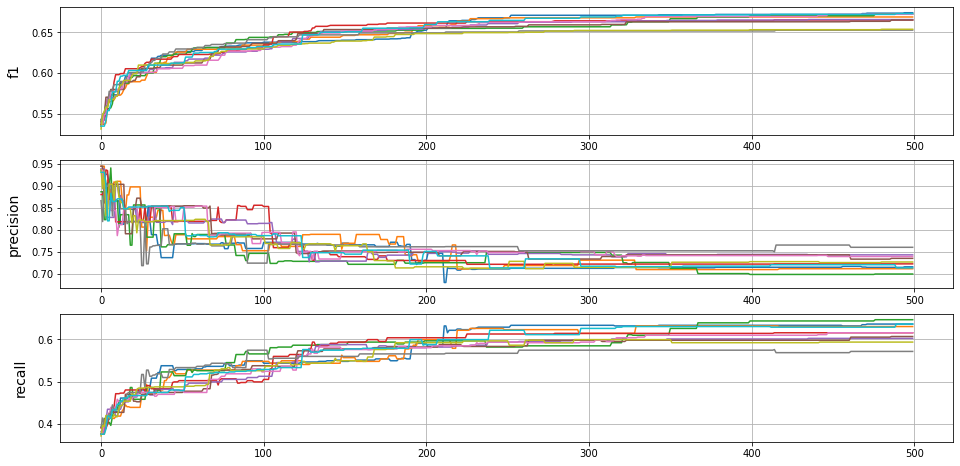

In [26]:
original_hs.plot_training_curve()

In [27]:
original_hs.evaluate(features_test, labels_test)

{'f1': '0.6876 ± 0.01785',
 'precision': '0.7562 ± 0.01403',
 'recall': '0.6315 ± 0.03254'}

## Improved HS

In [30]:
from source.harmony_searches.improved import ImprovedHS

In [31]:
PAR_MIN = 0.35
PAR_MAX = 0.99

In [32]:
improved_hs = ImprovedHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr=HMCR,
    par_min=PAR_MIN,
    par_max=PAR_MAX
)

In [33]:
%%time

improved_hs.fit(features_train, labels_train)

Wall time: 10min 22s


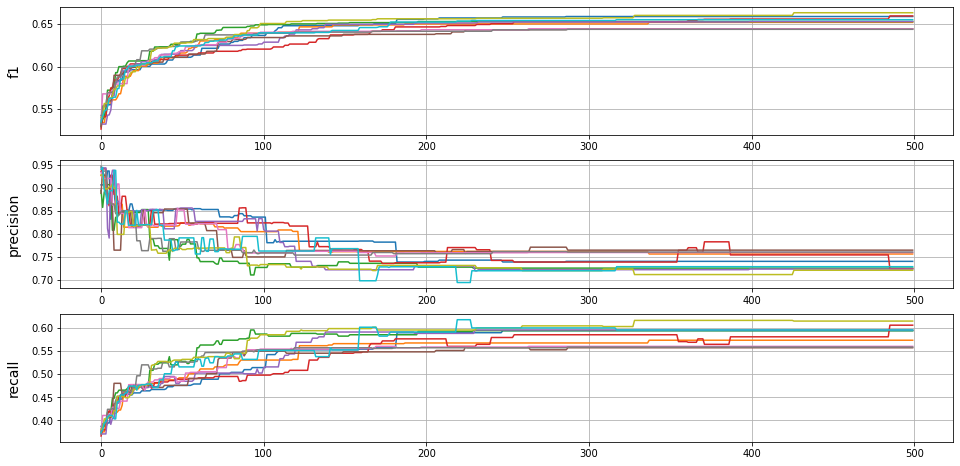

In [34]:
improved_hs.plot_training_curve()

In [35]:
improved_hs.evaluate(features_test, labels_test)

{'f1': '0.6671 ± 0.02174',
 'precision': '0.7573 ± 0.00899',
 'recall': '0.5971 ± 0.03459'}

## Parameter Adaptive HS

In [38]:
from source.harmony_searches.parameter_adaptive import ParameterAdaptiveHS

In [39]:
HMCR_MIN = 0.7
HMCR_MAX = 0.99

In [40]:
parameter_adaptive_hs = ParameterAdaptiveHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr_min=HMCR_MIN,
    hmcr_max=HMCR_MAX,
    par_min=PAR_MIN,
    par_max=PAR_MAX
)

In [41]:
%%time

parameter_adaptive_hs.fit(features_train, labels_train)

Wall time: 10min 48s


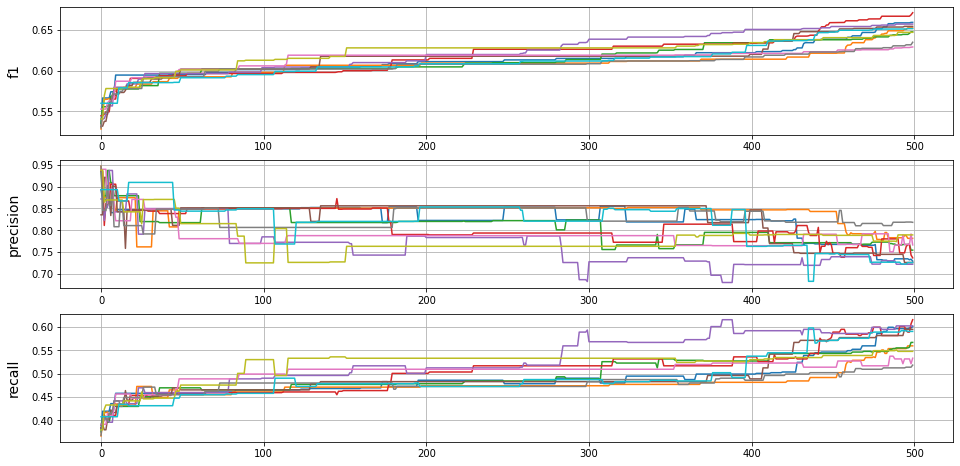

In [42]:
parameter_adaptive_hs.plot_training_curve()

In [43]:
parameter_adaptive_hs.evaluate(features_test, labels_test)

{'f1': '0.6732 ± 0.02305',
 'precision': '0.7773 ± 0.03095',
 'recall': '0.5958 ± 0.0387'}

## Statistical Tests

### Mean Histories Visualization

In [70]:
import matplotlib.pyplot as plt
import numpy as np

In [75]:
histories_dict = {
    "original": original_hs.histories_,
    "improved": improved_hs.histories_,
    "parameter_adaptive": parameter_adaptive_hs.histories_
}

fitness_dict = {}
for key, histories in histories_dict.items():
    fitness_dict[key] = []
    for history in histories:
        fitness = []
        for generation in history:
            best_fitness = max([solution[1].f1 for solution in generation])
            fitness.append(best_fitness)
        fitness_dict[key].append(fitness)

mean_fitness_dict = {}
for key, history in fitness_dict.items():
    mean_fitness_dict[key] = []
    for i in range(len(history[0])):
        mean_fitness = np.mean([history[j][i] for j in range(len(history))])
        mean_fitness_dict[key].append(mean_fitness)

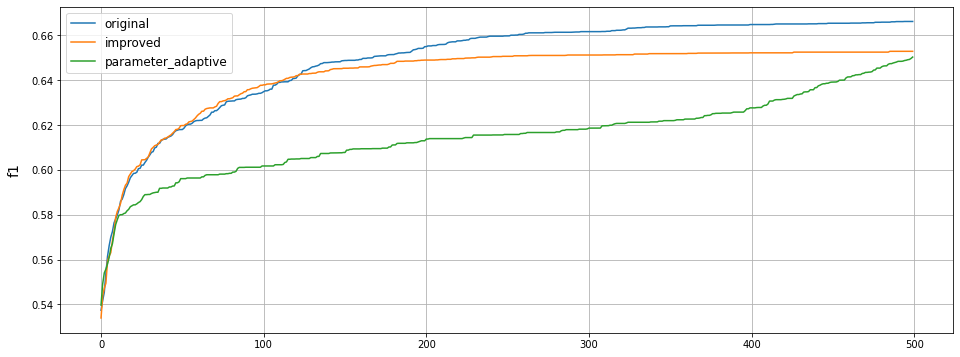

In [87]:
plt.figure(figsize=(16, 6))
for key, values in mean_fitness_dict.items():
    plt.plot(values, label=key)
plt.legend(loc="upper left", prop={"size": 12})
plt.ylabel("f1", size=14, labelpad=10)
plt.grid(True)
plt.show()

### Wilcoxon Signed-rank Test

In [89]:
wilcoxon_test = {
    "original - improved": wilcoxon.test(original_hs.histories_, improved_hs.histories_),
    "original - parameter_adaptive": wilcoxon.test(original_hs.histories_, parameter_adaptive_hs.histories_),
    "improved - parameter_adaptive": wilcoxon.test(improved_hs.histories_, parameter_adaptive_hs.histories_),
}

wilcoxon_test

{'original - improved': 0.009765625,
 'original - parameter_adaptive': 0.00390625,
 'improved - parameter_adaptive': 0.625}

### Page's Convergence Test

In [92]:
page_test = {
    "original - improved": page.test(original_hs.histories_, improved_hs.histories_),
    "original - parameter_adaptive": page.test(original_hs.histories_, parameter_adaptive_hs.histories_),
    "improved - parameter_adaptive": page.test(improved_hs.histories_, parameter_adaptive_hs.histories_),
}

page_test

{'original - improved': 2.2943424937693635e-10,
 'original - parameter_adaptive': 0.019778020767814708,
 'improved - parameter_adaptive': 2.3688004685551434e-07}